In [40]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import networkx.algorithms.community as nx_comm
from community import community_louvain
import matplotlib.cm as cm

In [41]:
votes_df = pd.read_csv(f"datasets/votacoesVotos-2021.csv", delimiter=";")
votes_df = votes_df[['idVotacao',
                         'deputado_id', 'deputado_nome',
                         'deputado_siglaPartido']]
votes_df = votes_df.rename(columns={"deputado_siglaPartido": "siglaBancada"})

votes_grouped_df = votes_df.groupby(by=["deputado_id", "deputado_nome", "siglaBancada"]).agg({'idVotacao': lambda x: ','.join(x),}).reset_index()
GO = nx.read_weighted_edgelist("networks/vote19-20-21-orientado-not-normalized.txt", nodetype=int)
GL = nx.read_weighted_edgelist("networks/vote19-20-21-liberado-not-normalized.txt", nodetype=int)

In [42]:
dep_sigla_dict = dict(zip(votes_grouped_df['deputado_id'], votes_grouped_df['siglaBancada']))
nx.set_node_attributes(GO, dep_sigla_dict, name="party")
nx.set_node_attributes(GL, dep_sigla_dict, name="party")

In [43]:
dg_GO = np.array([int(dg) for (nd, dg) in GO.degree()])
dg_GL = np.array([int(dg) for (nd, dg) in GL.degree()])

In [44]:
# Characterization ORIENTADO
print(f"Nodes: {GO.number_of_nodes()}")
print(f"Edges: {GO.number_of_edges()}")
print(f"Global: {nx.transitivity(GO)}")
print(f"Degree max, min, mean, std: {dg_GO.max()}, "
      f"{dg_GO.min()}, {dg_GO.mean()}, {dg_GO.std()}")

Nodes: 574
Edges: 158660
Global: 0.9770311042909179
Degree max, min, mean, std: 573, 91, 552.822299651568, 44.88929228623447


In [45]:
# Characterization LIBERADO
print(f"Nodes: {GL.number_of_nodes()}")
print(f"Edges: {GL.number_of_edges()}")
print(f"Global: {nx.transitivity(GL)}")
print(f"Degree max, min, mean, std: {dg_GL.max()}, "
      f"{dg_GL.min()}, {dg_GL.mean()}, {dg_GL.std()}")

Nodes: 559
Edges: 31653
Global: 0.587510858298792
Degree max, min, mean, std: 260, 3, 113.24865831842575, 60.83786535824848


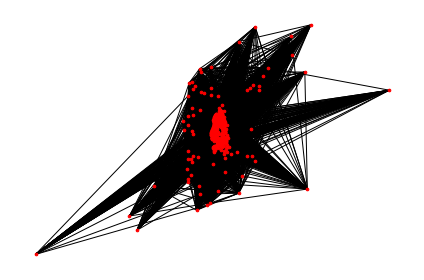

In [46]:
# Draw graph
elarge = [(u, v) for (u, v, d) in GO.edges(data=True) if d["weight"] >= 0.5]
esmall = [(u, v) for (u, v, d) in GO.edges(data=True) if d["weight"] < 0.5]

pos = nx.spring_layout(GO, seed=7)
nx.draw_networkx_nodes(GO, pos, node_size=7, node_color="red")
nx.draw_networkx_edges(GO, pos, edgelist=elarge, width=1)
nx.draw_networkx_edges(
    GO, pos, edgelist=esmall, width=1, alpha=0.5, edge_color="grey", style="dashed"
)
ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

In [47]:
# Modularity
g_communities = nx_comm.greedy_modularity_communities(GO)
print(nx_comm.modularity(GO, list(g_communities)))

0.0


In [49]:
lv_communities = community_louvain.best_partition(GL)
new_dict = {}
for k, v in lv_communities.items():
    new_dict.setdefault(v, []).append(k)
lv = list(new_dict.values())
print(nx_comm.modularity(GL, lv))

0.4147972576786701


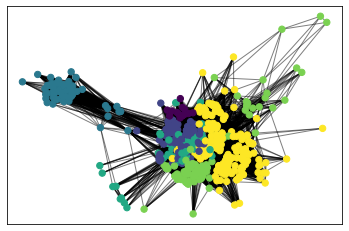

In [50]:
# draw the graph
pos = nx.spring_layout(GL)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(lv_communities.values()) + 1)
nx.draw_networkx_nodes(GL, pos, lv_communities.keys(), node_size=40,
                       cmap=cmap, node_color=list(lv_communities.values()))
nx.draw_networkx_edges(GL, pos, alpha=0.5)
plt.show()